<a href="https://colab.research.google.com/github/simonfei123/6DRepNet/blob/master/OpenAI_CLIP_adversarial_images_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial examples and their generalization for the OpenAI CLIP model

In this Colab I first verify the zero-shot performance of the OpenAI CLIP model (https://github.com/openai/CLIP) on CIFAR-10, reaching approximately 87.8%. I then show that **CLIP has adversarial examples** -- slight perturbations to images that lead to confident misclassification by the model. Developing several of such adversaries, I show that they generalize to semantically similar descriptions of the class towards which they were developed. For example, an image of a "jet" modified to look like a "cat" will also look like a "kitty" and "domesticated animal that eats mice and meows" to CLIP. This shows that the adversarial images actually do *look* like the other class to the classifier and that they are not brittle under the semantically related changes of class descriptions.



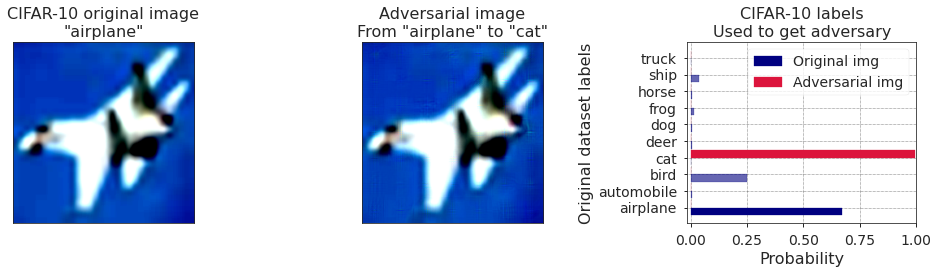

# Dependencies

In [1]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

import numpy as np
import torch

print("Torch version:", torch.__version__)

import matplotlib.pyplot as plt

CUDA version: 12.5
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu110 (from versions: 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.1.0+cu121.with.pypi.cudnn, 2.1.0+rocm5.5, 2.1.0+rocm5.6, 2.1.1, 2.1.1+cpu, 2.1.1+cpu.cxx11.abi, 2.1.1+cu118, 2.1.1+cu121, 2.1.1+cu121.with.pypi.cudnn, 2.1.1+rocm5.5, 2.1.1+rocm5.6, 2.1.2, 2.1.2+cpu, 2.1.2+cpu.cxx11.abi, 2.1.2+cu118, 2.1.2+cu121, 2.1.2+cu121.with.pypi.cudnn, 2.1.2+rocm5.5, 2.1.2+rocm5.6, 2.2.0, 2.2.0+cpu, 2.2.0+cpu.cxx11.abi, 2.2.0+cu118, 2.2.0+cu121, 2

# Downloading OpenAI CLIP from GitHub

In [2]:
#clone the CLIP repository
!git clone https://github.com/openai/CLIP.git
%cd CLIP

Cloning into 'CLIP'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 256 (delta 126), reused 110 (delta 110), pack-reused 102 (from 1)
Receiving objects: 100% (256/256), 8.86 MiB | 12.91 MiB/s, done.
Resolving deltas: 100% (140/140), done.
/content/CLIP


# Getting CIFAR-10 and CIFAR-100

## Choose dataset

In [3]:
#choose either CIFAR-10 or CIFAR-100

dataset_choice = "CIFAR10"
# dataset_choice = "CIFAR100"

## Load dataset

In [4]:
import keras
from keras.datasets import cifar10,cifar100

if dataset_choice == "CIFAR10":
  classes = 10
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
elif dataset_choice == "CIFAR100":
  classes = 100
  (x_train, y_train), (x_test, y_test) = cifar100.load_data()

y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])

N_train = len(y_train)

# Input image dimensions.
input_shape = x_train.shape[1:]

#keeping the originals
x_train_unnormed = np.array(x_train)
x_test_unnormed = np.array(x_test)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


## Original class names

In [5]:
cifar10_class_names = [
  "airplane",
  "automobile",
  "bird",
  "cat",
  "deer",
  "dog",
  "frog",
  "horse",
  "ship",
  "truck"
  ]


cifar100_class_names = [
  'apple',
  'aquarium_fish',
  'baby',
  'bear',
  'beaver',
  'bed',
  'bee',
  'beetle',
  'bicycle',
  'bottle',
  'bowl',
  'boy',
  'bridge',
  'bus',
  'butterfly',
  'camel',
  'can',
  'castle',
  'caterpillar',
  'cattle',
  'chair',
  'chimpanzee',
  'clock',
  'cloud',
  'cockroach',
  'couch',
  'crab',
  'crocodile',
  'cup',
  'dinosaur',
  'dolphin',
  'elephant',
  'flatfish',
  'forest',
  'fox',
  'girl',
  'hamster',
  'house',
  'kangaroo',
  'computer_keyboard',
  'lamp',
  'lawn_mower',
  'leopard',
  'lion',
  'lizard',
  'lobster',
  'man',
  'maple_tree',
  'motorcycle',
  'mountain',
  'mouse',
  'mushroom',
  'oak_tree',
  'orange',
  'orchid',
  'otter',
  'palm_tree',
  'pear',
  'pickup_truck',
  'pine_tree',
  'plain',
  'plate',
  'poppy',
  'porcupine',
  'possum',
  'rabbit',
  'raccoon',
  'ray',
  'road',
  'rocket',
  'rose',
  'sea',
  'seal',
  'shark',
  'shrew',
  'skunk',
  'skyscraper',
  'snail',
  'snake',
  'spider',
  'squirrel',
  'streetcar',
  'sunflower',
  'sweet_pepper',
  'table',
  'tank',
  'telephone',
  'television',
  'tiger',
  'tractor',
  'train',
  'trout',
  'tulip',
  'turtle',
  'wardrobe',
  'whale',
  'willow_tree',
  'wolf',
  'woman',
  'worm',
]


In [6]:
if dataset_choice == "CIFAR10":
  candidate_captions = cifar10_class_names
  class_names = cifar10_class_names
elif dataset_choice == "CIFAR100":
  candidate_captions = cifar100_class_names
  class_names = cifar100_class_names

# Run CLIP on the test set to check performance

In [8]:
!pip install ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.7 MB/s eta 0:00:00


In [9]:
import torch
import clip
from PIL import Image

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

model, transform = clip.load("ViT-B/32", device=device) #loading the clip checkpoints

text = clip.tokenize(candidate_captions).to(device) #tokenizing the candidate labels

#for on the fly accuracy estimate
collecting_predictions_list = []
collecting_ground_truth_list = []

N_to_check = -1 #full dataset
# N_to_check = 500 #first 500

for i,img in enumerate(x_test_unnormed[:N_to_check]):

  if i % 100 == 0:
    if len(collecting_predictions_list) > 0:
      collecting_predictions_np = np.concatenate(collecting_predictions_list,axis=0)
      acc_now = np.mean(np.array(collecting_ground_truth_list) == np.argmax(collecting_predictions_np,axis=-1))
    else:
      acc_now = None
    print(str(i)+"/"+str(len(x_test_unnormed[:N_to_check]))+" test accuracy so far="+str(acc_now))

  img_PIL = Image.fromarray(np.uint8(img))
  image = transform(img_PIL).unsqueeze(0).to(device)

  with torch.no_grad():

    logits_from_image, logits_from_text = model(image, text)
    probs_now = logits_from_image.softmax(dim=-1).cpu().numpy()

    collecting_predictions_list.append(probs_now)
    collecting_ground_truth_list.append(y_test[i])





100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 52.1MiB/s]


0/9999 test accuracy so far=None
100/9999 test accuracy so far=0.87
200/9999 test accuracy so far=0.865
300/9999 test accuracy so far=0.8766666666666667
400/9999 test accuracy so far=0.8825
500/9999 test accuracy so far=0.88
600/9999 test accuracy so far=0.8783333333333333
700/9999 test accuracy so far=0.8771428571428571
800/9999 test accuracy so far=0.8775
900/9999 test accuracy so far=0.88
1000/9999 test accuracy so far=0.876
1100/9999 test accuracy so far=0.8754545454545455
1200/9999 test accuracy so far=0.8766666666666667
1300/9999 test accuracy so far=0.8792307692307693
1400/9999 test accuracy so far=0.8778571428571429
1500/9999 test accuracy so far=0.8786666666666667
1600/9999 test accuracy so far=0.88
1700/9999 test accuracy so far=0.8823529411764706
1800/9999 test accuracy so far=0.8833333333333333
1900/9999 test accuracy so far=0.8831578947368421
2000/9999 test accuracy so far=0.8825
2100/9999 test accuracy so far=0.8828571428571429
2200/9999 test accuracy so far=0.88
2300/999

In [10]:
y_test

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

In [13]:
probs_now

array([[0.775   , 0.04373 , 0.09406 , 0.001777, 0.004467, 0.006107,
        0.006107, 0.0076  , 0.05273 , 0.00835 ]], dtype=float16)

## Test set accuracy

In [ ]:
collecting_predictions_np = np.concatenate(collecting_predictions_list,axis=0)
acc_now = np.mean(np.array(collecting_ground_truth_list) == np.argmax(collecting_predictions_np,axis=-1))
print("Test accuracy = "+str(acc_now))

Test accuracy = 0.8736873687368737


# Encapsulating classification into wrapper

In [ ]:
def classify_images(images_np, class_texts, skip_transform = False,verbose = True):

  text = clip.tokenize(class_texts).to(device)

  collecting_predictions_list = []
  collecting_ground_truth_list = []

  for i,img in enumerate(images_np):

    if verbose and (i % 50 == 0):
      print(i)


    if skip_transform == False:
      img_PIL = Image.fromarray(np.uint8(img))
      image = transform(img_PIL).unsqueeze(0).to(device)
    else:
      image = torch.Tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():

      logits_from_image, logits_from_text = model(image, text)
      probs = logits_from_image.softmax(dim=-1).cpu().numpy()

      collecting_predictions_list.append(probs)
      collecting_ground_truth_list.append(y_test[i])

  return np.concatenate(collecting_predictions_list,axis=0)


In [ ]:
subset_size = 1000
preds_now = classify_images(x_train_unnormed[:subset_size], class_names)
acc_now = np.mean(np.argmax(preds_now,axis=-1) == y_train[:subset_size])
print("train subset accuracy = "+str(acc_now))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
train subset accuracy = 0.865


# Generating adversarial examples

# Trying adversarial examples

## Plotting style

In [ ]:
import matplotlib as mpl
import seaborn as sns
sns.set_style("ticks")

mpl.style.use('seaborn-notebook')
mpl.rcParams.update({'font.size': 14, 'lines.linewidth': 2, 'figure.figsize': (6, 6/1.61)})
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

DEFAULT_FONTSIZE = 13
mpl.rcParams.update({'font.size': DEFAULT_FONTSIZE, 'lines.linewidth': 2,
                    'legend.fontsize': DEFAULT_FONTSIZE, 'axes.labelsize': DEFAULT_FONTSIZE,
                    'xtick.labelsize': DEFAULT_FONTSIZE, 'ytick.labelsize': DEFAULT_FONTSIZE, 'figure.figsize': (7, 7.0/1.4)})

markers_list = ["o","x","D","*","^"]


plt.rcParams['svg.fonttype'] = 'none'

## Simple optimization loop to get adversaries

In [ ]:
for p in model.parameters():
  p.requires_grad = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label = 0
Target label = 3
step=0 targetloss=6.3 p[true=0]=0.6733 p[target=3]=0.001833


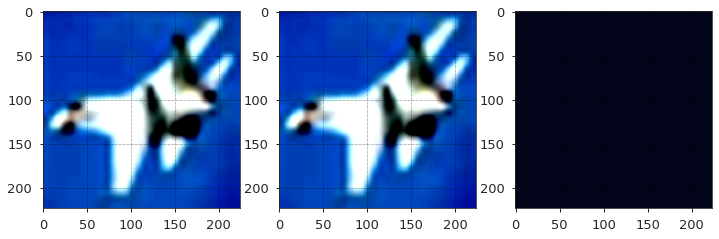

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step=10 targetloss=0.04865 p[true=0]=0.0118 p[target=3]=0.9526


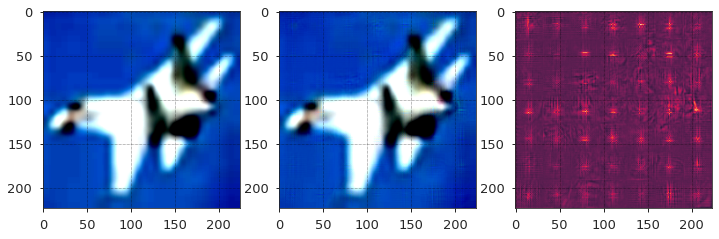

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step=20 targetloss=0.0202 p[true=0]=0.003168 p[target=3]=0.98


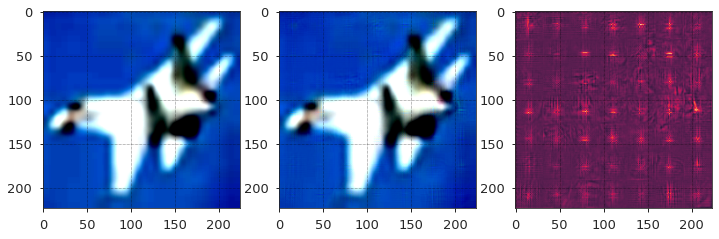

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step=30 targetloss=0.01321 p[true=0]=0.001656 p[target=3]=0.987


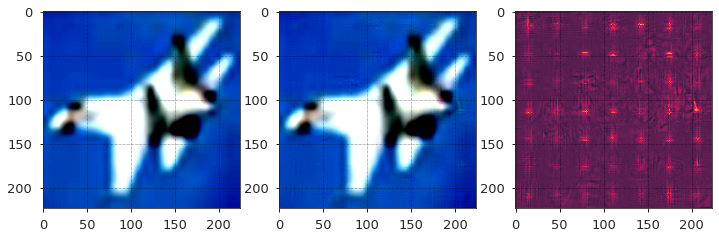

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step=40 targetloss=0.009636 p[true=0]=0.001007 p[target=3]=0.99


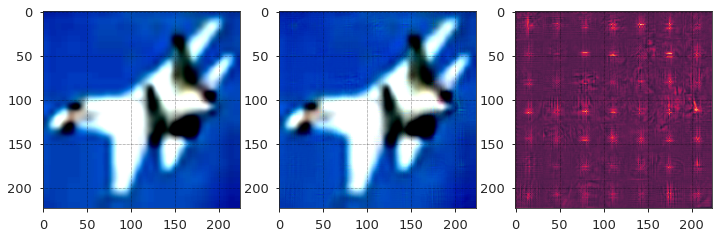

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step=50 targetloss=0.007385 p[true=0]=0.0006223 p[target=3]=0.9927


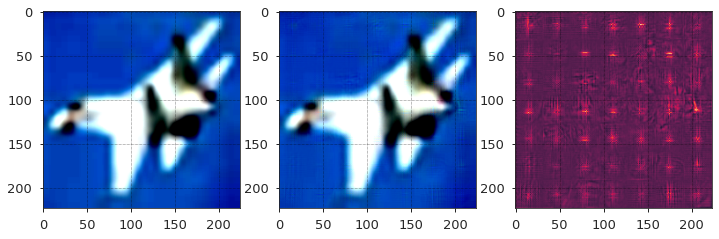

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step=60 targetloss=0.005943 p[true=0]=0.0004215 p[target=3]=0.994


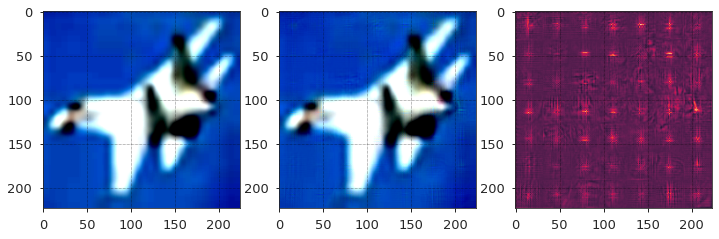

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step=70 targetloss=0.005154 p[true=0]=0.0003285 p[target=3]=0.9946


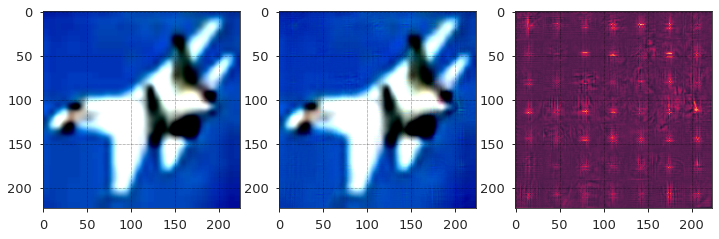

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step=80 targetloss=0.004593 p[true=0]=0.0002642 p[target=3]=0.9956


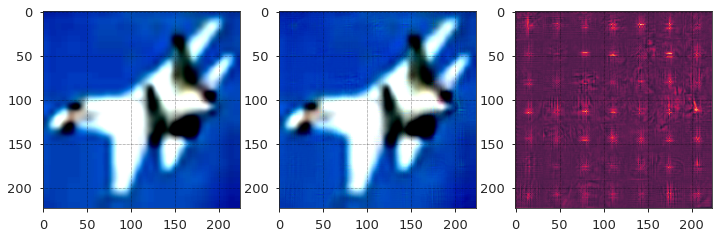

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step=90 targetloss=0.0041 p[true=0]=0.0002156 p[target=3]=0.996


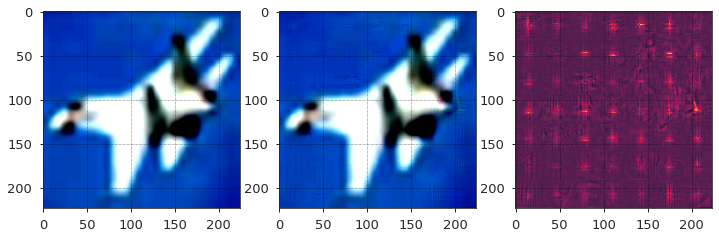

In [ ]:
id_chosen = 10 #choosing an example image to get an adversary to

img_PIL = Image.fromarray(np.uint8(x_test_unnormed[id_chosen]))
image = transform(img_PIL).unsqueeze(0).to(device)

image_original_np = image.detach().cpu().numpy()

true_label = y_test[id_chosen]
print("True label = "+str(true_label))

target_label = 3
print("Target label = "+str(target_label))

LR = 0.5 #LR for the image changes
steps = 100 #the number of steps to get adversary

for step in range(steps):

  image_np = image.detach().cpu().numpy()

  #getting the model for grad setup
  criterion = torch.nn.CrossEntropyLoss()

  inputs = image
  labels = torch.Tensor([target_label]).reshape([1]).to(device)

  inputs.requires_grad = True

  outputs, _ = model(image, text)
  probs = outputs.softmax(dim=-1).detach().cpu().numpy()

  loss = criterion(outputs, labels.long())

  inputs.retain_grad()
  loss.retain_grad()

  loss.backward()

  loss_out_np = loss.data.detach().cpu().numpy()


  if step % 10 == 0:
    print(
      "step="+str(step)+
      " targetloss="+str(loss_out_np)+
      " p[true="+str(true_label)+"]="+str(probs[0,true_label])+
      " p[target="+str(target_label)+"]="+str(probs[0,target_label])
    )

    plt.figure(figsize=(3*4,4))
    plt.subplot(1,3,1)
    plt.imshow(image_original_np[0].transpose([1,2,0]))
    plt.subplot(1,3,2)
    plt.imshow(image_np[0].transpose([1,2,0]))
    plt.subplot(1,3,3)
    plt.imshow(np.max(image_np[0]-image_original_np[0],axis=0))
    plt.show()


  image_grad = inputs.grad.detach().cpu().numpy()

  image_np = image.detach().cpu().numpy() - LR*image_grad #taking the image step
  image = torch.Tensor(image_np)


## Verifying the adversary

### Getting predictions for original and adversary

In [ ]:
orig_preds = classify_images(
    np.concatenate([image_original_np],axis=0),
    class_names, skip_transform=True, verbose=False)

mod_preds = classify_images(
    np.concatenate([image_np],axis=0),
    class_names, skip_transform=True, verbose=False)


### Plotting function

In [ ]:
def make_plot_from_preds(orig_preds,mod_preds,class_labels,colors = ["navy","crimson"]):

  width = 0.45

  for i in range(orig_preds.shape[0]):
    v_orig = orig_preds[i]
    v_mod = mod_preds[i]

    label1 = ""
    label2 = ""

    alpha_mod = 0.6
    alpha_orig = 0.6

    if np.argmax(mod_preds) == i:
      alpha_mod = 1.0
      label2 = "Adversarial img"
    if np.argmax(orig_preds) == i:
      alpha_orig = 1.0
      label1 = "Original img"

    plt.fill_between([0,v_mod],[i,i],[i+width,i+width], color = colors[1],label = label2, alpha = alpha_mod)
    plt.fill_between([0,v_orig],[i-width,i-width],[i,i], color = colors[0],label = label1, alpha = alpha_orig)

  plt.yticks(range(len(class_labels)),class_labels,fontsize = 14)#, rotation = 45)

  plt.xticks(fontsize = 14)

  plt.xlabel("Probability",fontsize = 16)
  plt.ylabel("New dataset labels",fontsize = 16)

  plt.legend(fontsize = 14)#,loc = "center right")

  plt.xlim([-0.015,1.0])


### Nice plot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


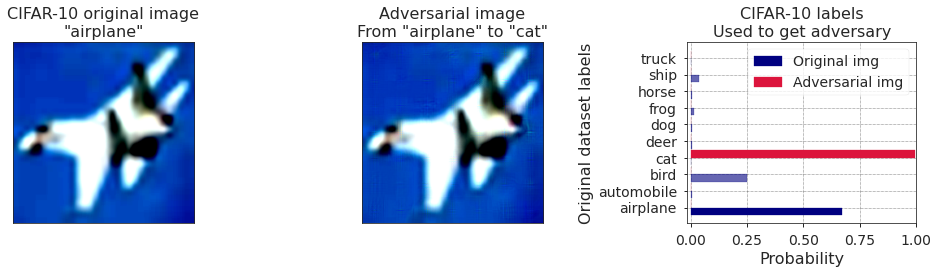

In [ ]:
plt.figure(figsize = (3*4.5,4))

plt.subplot(1,3,3)
plt.title("CIFAR-10 labels\nUsed to get adversary",fontsize = 16)
make_plot_from_preds(orig_preds[0],mod_preds[0],class_names)
plt.ylabel("Original dataset labels")

plt.subplot(1,3,1)
plt.title("CIFAR-10 original image\n\""+class_names[np.argmax(orig_preds[0])]+"\"",fontsize = 16)
plt.imshow(image_original_np[0].transpose([1,2,0]))
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,2)
plt.title("Adversarial image\nFrom \""+class_names[np.argmax(orig_preds[0])]+"\" to \""+class_names[np.argmax(mod_preds[0])]+"\"",fontsize = 16)
plt.imshow(image_np[0].transpose([1,2,0]))
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])

plt.tight_layout()

plt.show()

## Making a bunch of adversarial images

In [ ]:
def get_different_class(c_true,classes = 10):
  classes_kept = [c for c in range(classes) if c!=c_true]
  return int(np.random.choice(classes_kept,()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label = 0
Target label = 4
image=0/10 step=0 targetloss=3.82 p[true=0]=0.5483 p[target=4]=0.02193


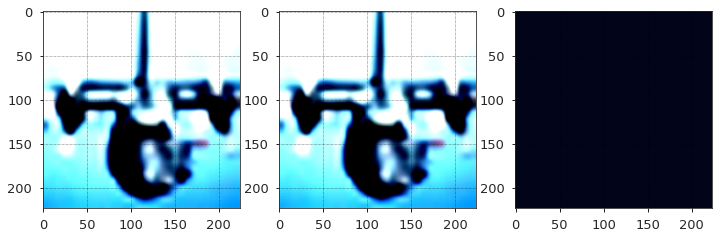

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image=0/10 step=29 targetloss=0.085 p[true=0]=0.00669 p[target=4]=0.9185


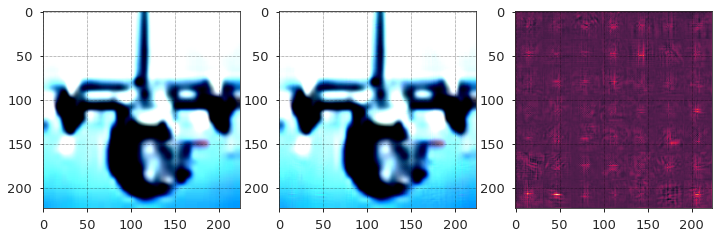

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label = 1
Target label = 4
image=1/10 step=0 targetloss=6.523 p[true=1]=0.978 p[target=4]=0.001471


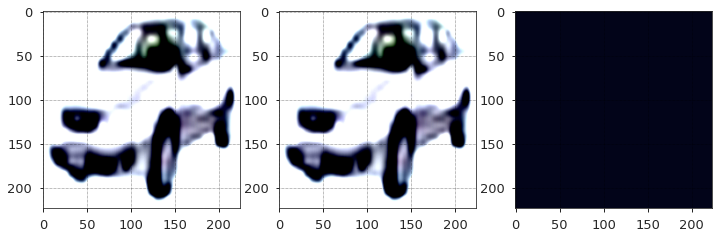

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image=1/10 step=29 targetloss=0.02463 p[true=1]=0.01482 p[target=4]=0.9756


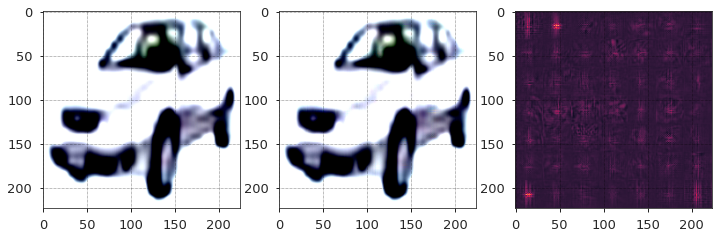

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label = 0
Target label = 1
image=2/10 step=0 targetloss=4.777 p[true=0]=0.7954 p[target=1]=0.00843


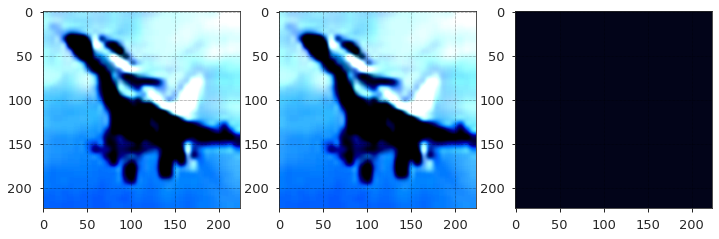

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image=2/10 step=29 targetloss=0.0604 p[true=0]=0.04202 p[target=1]=0.9414


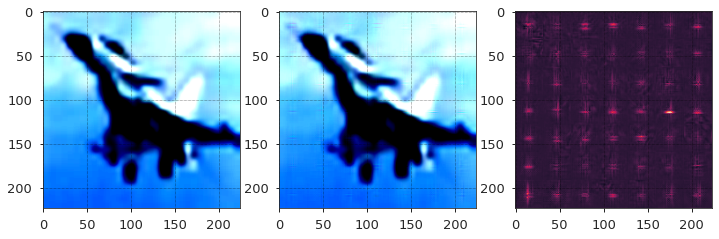

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label = 0
Target label = 6
image=3/10 step=0 targetloss=4.215 p[true=0]=0.9155 p[target=6]=0.01479


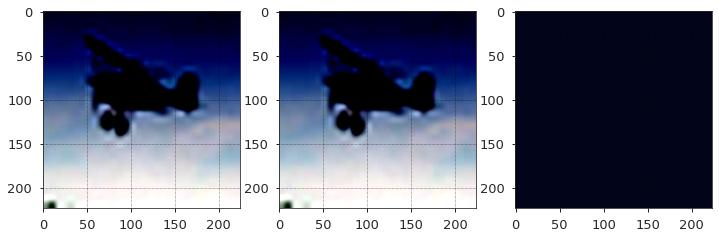

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image=3/10 step=29 targetloss=0.0244 p[true=0]=0.006275 p[target=6]=0.976


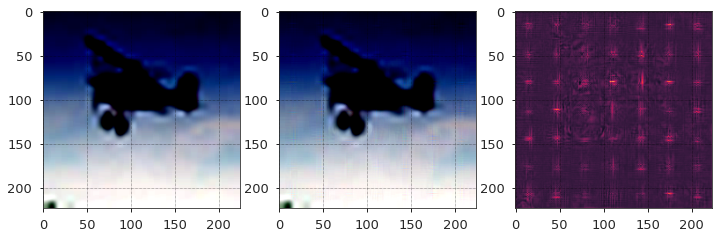

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label = 8
Target label = 0
image=4/10 step=0 targetloss=5.453 p[true=8]=0.984 p[target=0]=0.00428


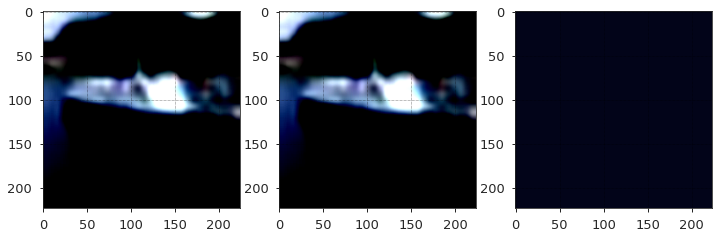

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image=4/10 step=29 targetloss=0.01616 p[true=8]=0.00878 p[target=0]=0.984


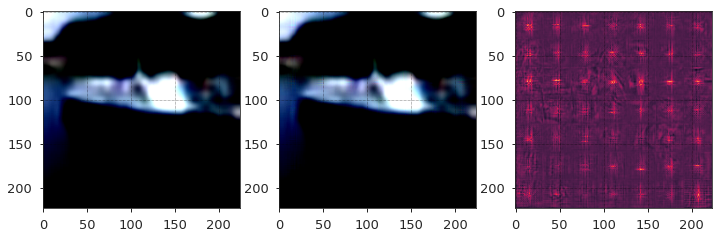

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label = 3
Target label = 1
image=5/10 step=0 targetloss=5.0 p[true=3]=0.8555 p[target=1]=0.00674


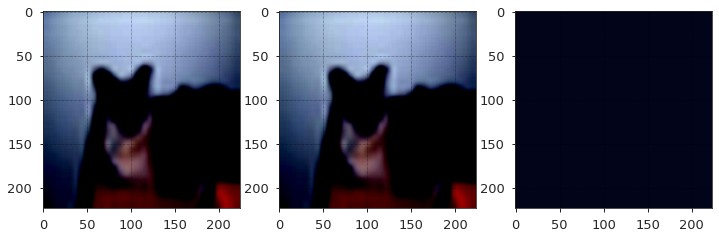

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image=5/10 step=29 targetloss=0.02594 p[true=3]=0.003712 p[target=1]=0.9746


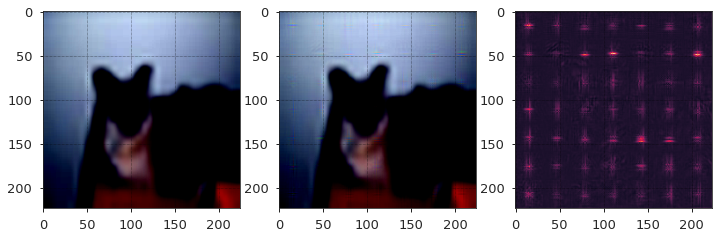

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label = 9
Target label = 8
image=6/10 step=0 targetloss=4.25 p[true=9]=0.743 p[target=8]=0.01427


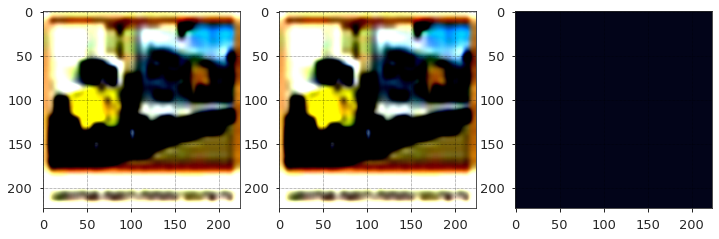

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image=6/10 step=29 targetloss=0.01923 p[true=9]=0.002016 p[target=8]=0.981


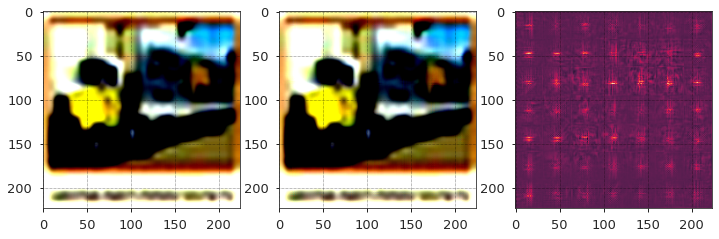

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label = 8
Target label = 7
image=7/10 step=0 targetloss=4.57 p[true=8]=0.847 p[target=7]=0.01034


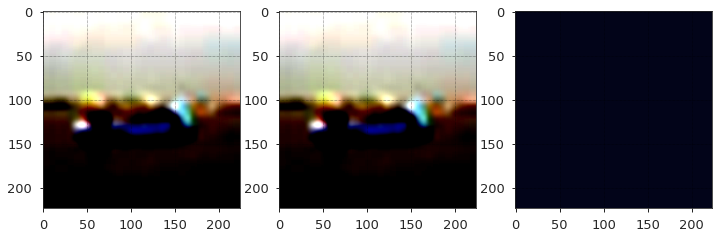

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image=7/10 step=29 targetloss=0.011185 p[true=8]=0.0009017 p[target=7]=0.989


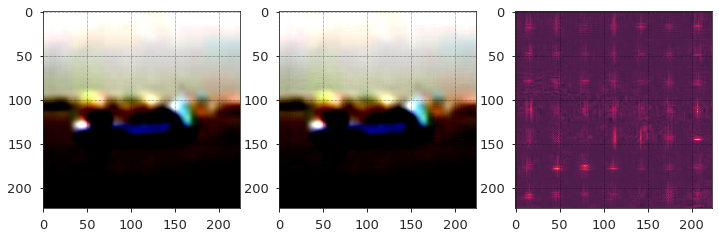

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label = 4
Target label = 0
image=8/10 step=0 targetloss=7.496 p[true=4]=0.9873 p[target=0]=0.0005546


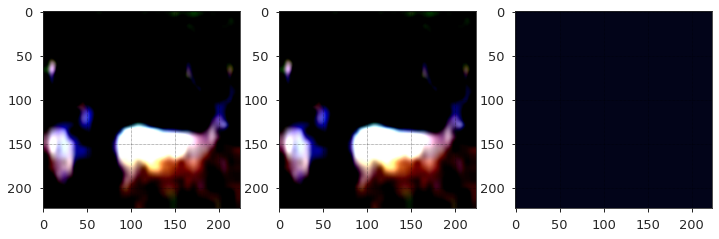

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image=8/10 step=29 targetloss=0.02281 p[true=4]=0.00311 p[target=0]=0.9775


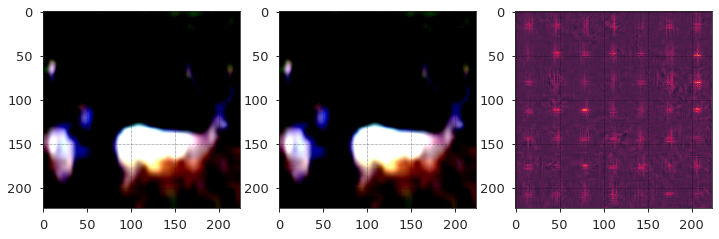

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True label = 5
Target label = 9
image=9/10 step=0 targetloss=5.766 p[true=5]=0.9253 p[target=9]=0.003134


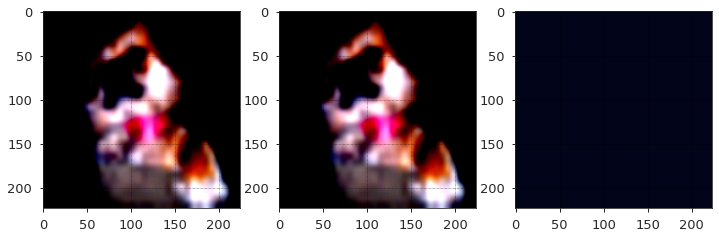

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image=9/10 step=29 targetloss=0.04718 p[true=5]=0.02208 p[target=9]=0.954


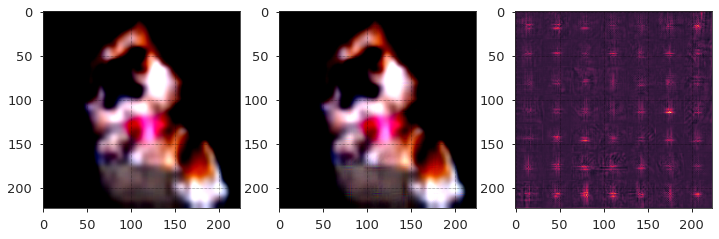

In [ ]:
N_adversaries = 10 #number of adversaries to make

#adversarial image optimization loop params
LR = 0.3
steps = 30

#collecting images and labels
collected_original_images = []
collected_original_labels = []
collected_modified_images = []
collected_modified_labels = []

for j in range(N_adversaries):

  id_chosen = int(np.random.choice(range(len(x_train_unnormed)),()))

  img_PIL = Image.fromarray(np.uint8(x_train_unnormed[id_chosen]))
  image = transform(img_PIL).unsqueeze(0).to(device)

  image_original_np = image.detach().cpu().numpy()

  collected_original_images.append(image_original_np)

  true_label = y_train[id_chosen]
  print("True label = "+str(true_label))

  collected_original_labels.append(true_label)

  target_label = get_different_class(int(true_label))
  print("Target label = "+str(target_label))

  collected_modified_labels.append(target_label)

  for step in range(steps):

    image_np = image.detach().cpu().numpy()

    #getting the model for grad setup
    criterion = torch.nn.CrossEntropyLoss()

    inputs = image
    labels = torch.Tensor([target_label]).reshape([1]).to(device)

    inputs.requires_grad = True

    outputs, _ = model(image, text)
    probs = outputs.softmax(dim=-1).detach().cpu().numpy()

    loss = criterion(outputs, labels.long())

    inputs.retain_grad()
    loss.retain_grad()

    loss.backward()

    loss_out_np = loss.data.detach().cpu().numpy()


    if step in [0,steps-1]:
      print(
        "image="+str(j)+"/"+str(N_adversaries)+
        " step="+str(step)+
        " targetloss="+str(loss_out_np)+
        " p[true="+str(true_label)+"]="+str(probs[0,true_label])+
        " p[target="+str(target_label)+"]="+str(probs[0,target_label])
      )

      plt.figure(figsize=(3*4,4))
      plt.subplot(1,3,1)
      plt.imshow(image_original_np[0].transpose([1,2,0]))
      plt.subplot(1,3,2)
      plt.imshow(image_np[0].transpose([1,2,0]))
      plt.subplot(1,3,3)
      plt.imshow(np.max(image_np[0]-image_original_np[0],axis=0))
      plt.show()

    image_grad = inputs.grad.detach().cpu().numpy()

    image_np = image.detach().cpu().numpy() - LR*image_grad
    image = torch.Tensor(image_np)

  collected_modified_images.append(image_np)


### Getting predictions with original CIFAR-10 names

In [ ]:
modified_preds_now = classify_images(np.concatenate(collected_modified_images,axis=0), class_names, skip_transform=True, verbose=False)
original_preds_now = classify_images(np.concatenate(collected_original_images,axis=0), class_names, skip_transform=True, verbose=False)

original_acc_now = np.mean(np.argmax(original_preds_now,axis=-1) == np.array(collected_original_labels))
modified_acc_now = np.mean(np.argmax(modified_preds_now,axis=-1) == np.array(collected_modified_labels))

print("Original images and original labels accuracy = "+str(original_acc_now))
print("Adversarial images and adversarial labels accuracy = "+str(modified_acc_now))

Original images and original labels accuracy = 1.0
Adversarial images and adversarial labels accuracy = 1.0


# Trying different class descriptions to see generality

In [ ]:
assert dataset_choice == "CIFAR10" #I only wrote the alternative names for CIFAR-10, you can easily modify to CIFAR-100

### Alternative class names

In [ ]:
#original class names
cifar10_class_names = [
  "airplane",
  "automobile",
  "bird",
  "cat",
  "deer",
  "dog",
  "frog",
  "horse",
  "ship",
  "truck"
]

#different alternative names that should be easy
cifar10_class_names_alternatives = [
  ["plane","aircraft","jet"],
  ["car","vehicle","auto"],
  ["avian","birdie"],
  ["feline","kitty"],
  ["reindeer","moose"],
  ["hound","doggy","doggo","doggie","puppy","pup","canine"],
  ["toad"],
  ["donkey","horsie"],
  ["tanker","sail ship", "boat"],
  ["lorry","rig","freighter"],
]


### Getting predictions for alternative class names

In [ ]:
for i in range(5):

  #choosing random alternative class names from my alternatives list
  alternative_class_names = [np.random.choice(names) for names in cifar10_class_names_alternatives]

  print("Checking "+str(i))
  print("class names = "+str(alternative_class_names))

  modified_preds_now = classify_images(np.concatenate(collected_modified_images,axis=0), alternative_class_names, skip_transform=True, verbose=False)
  original_preds_now = classify_images(np.concatenate(collected_original_images,axis=0), alternative_class_names, skip_transform=True, verbose=False)

  original_acc_now = np.mean(np.argmax(original_preds_now,axis=-1) == np.array(collected_original_labels))
  modified_acc_now = np.mean(np.argmax(modified_preds_now,axis=-1) == np.array(collected_modified_labels))

  print("Original images and original labels accuracy = "+str(original_acc_now))
  print("Adversarial images and adversarial labels accuracy = "+str(modified_acc_now))

  #original class names for comparison
  orignames_modified_preds_now = classify_images(np.concatenate(collected_modified_images,axis=0), class_names, skip_transform=True, verbose=False)
  orignames_original_preds_now = classify_images(np.concatenate(collected_original_images,axis=0), class_names, skip_transform=True, verbose=False)

Checking 0
class names = ['plane', 'auto', 'avian', 'kitty', 'reindeer', 'doggy', 'toad', 'donkey', 'sail ship', 'rig']
Original images and original labels accuracy = 0.9
Adversarial images and adversarial labels accuracy = 0.7
Checking 1
class names = ['aircraft', 'auto', 'avian', 'kitty', 'moose', 'doggy', 'toad', 'horsie', 'tanker', 'rig']
Original images and original labels accuracy = 0.9
Adversarial images and adversarial labels accuracy = 0.6
Checking 2
class names = ['plane', 'vehicle', 'birdie', 'feline', 'reindeer', 'puppy', 'toad', 'horsie', 'sail ship', 'rig']
Original images and original labels accuracy = 0.9
Adversarial images and adversarial labels accuracy = 0.7
Checking 3
class names = ['jet', 'auto', 'avian', 'feline', 'reindeer', 'pup', 'toad', 'horsie', 'sail ship', 'freighter']
Original images and original labels accuracy = 0.8
Adversarial images and adversarial labels accuracy = 0.5
Checking 4
class names = ['jet', 'car', 'avian', 'kitty', 'moose', 'pup', 'toad', '

### Plotting the CIFAR-10 and alternative names and the generality of adversaries

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


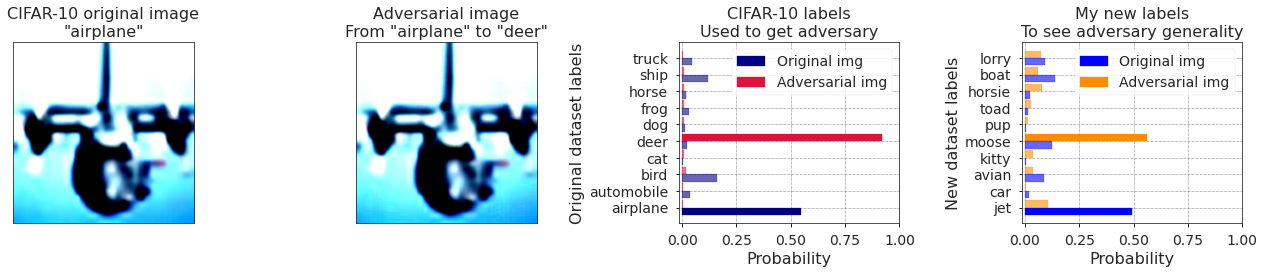

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


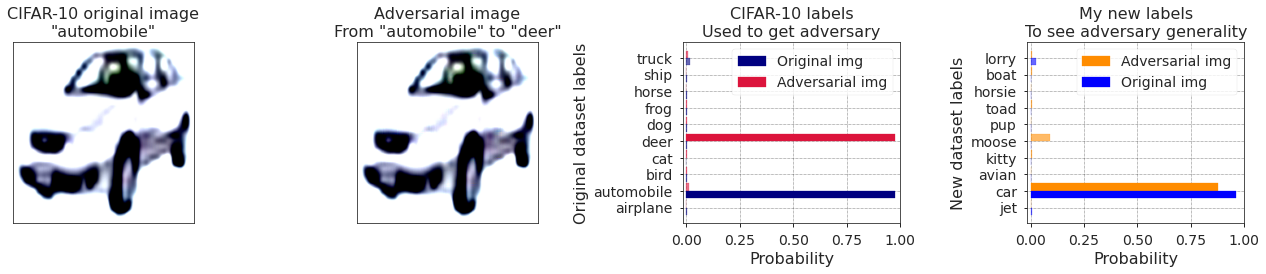

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


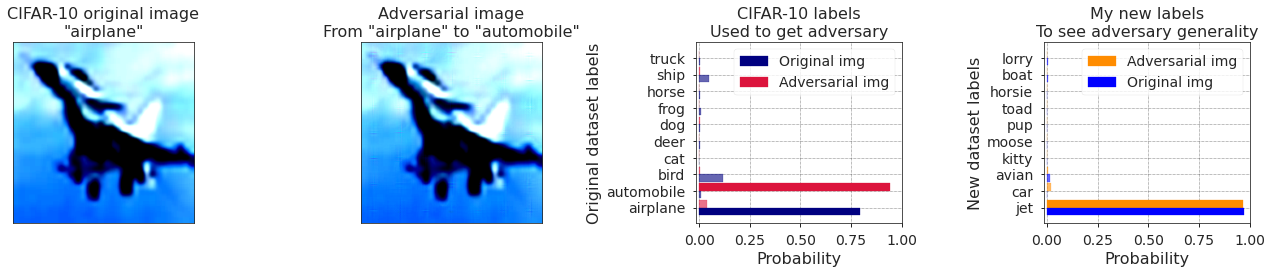

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


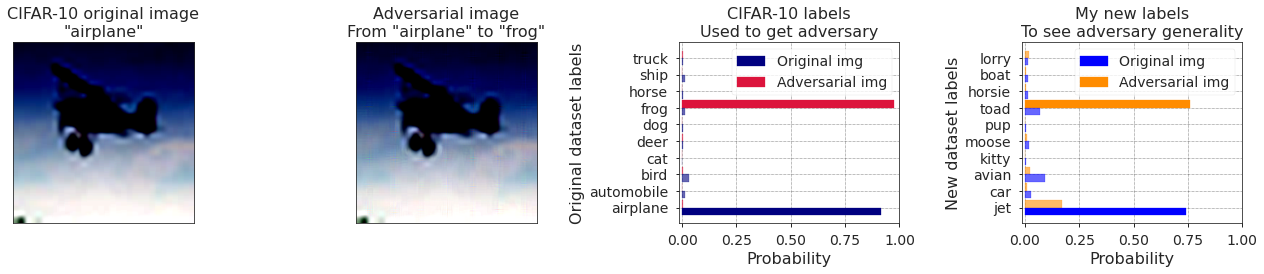

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


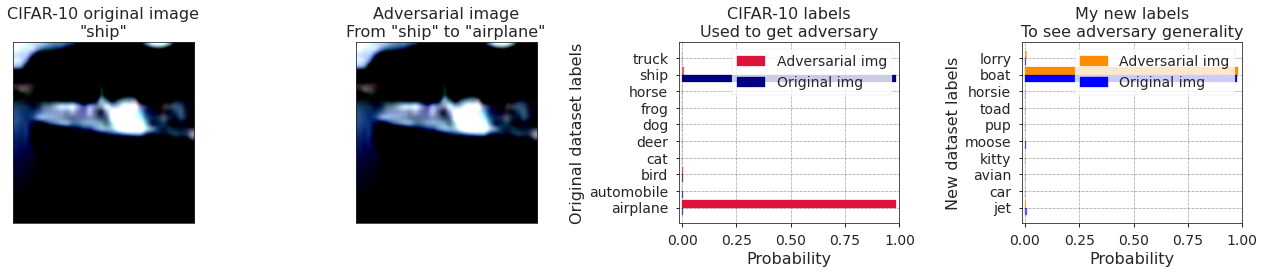

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


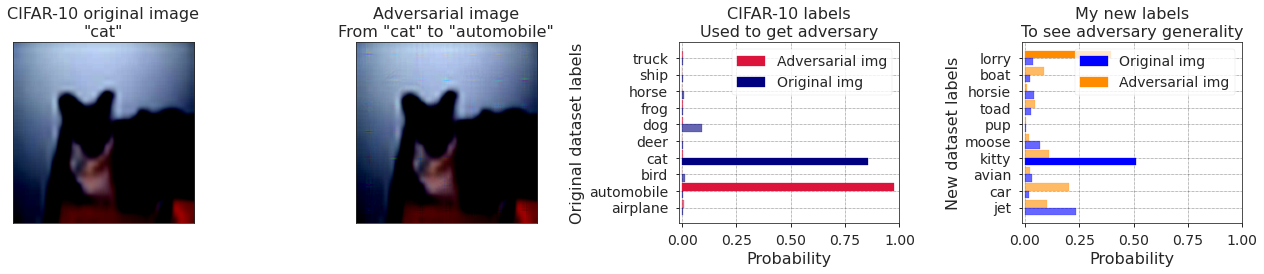

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


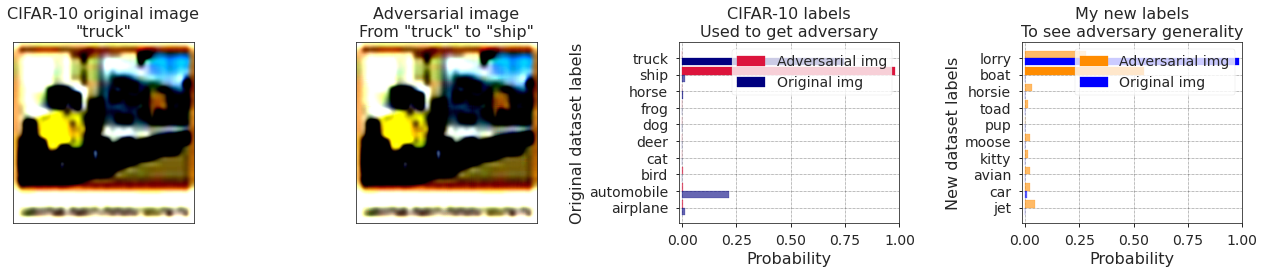

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


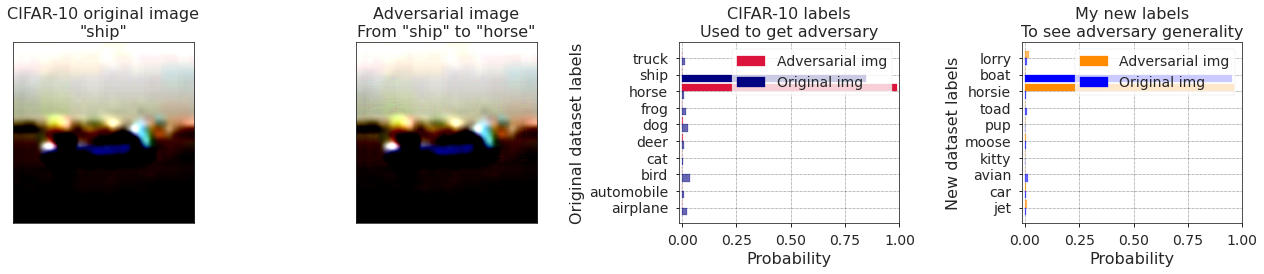

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


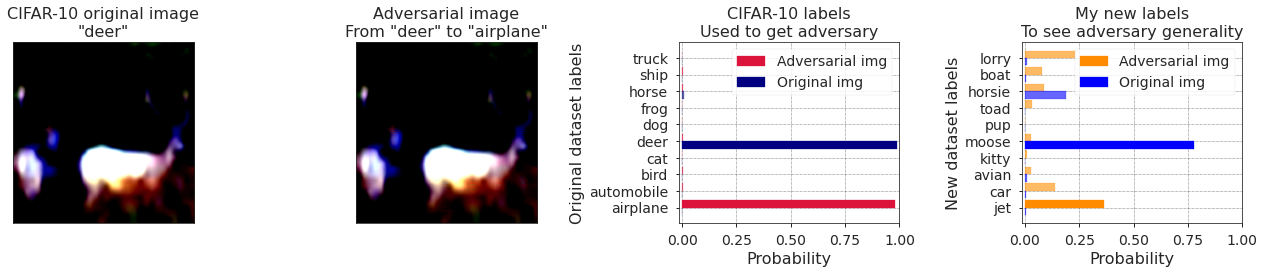

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


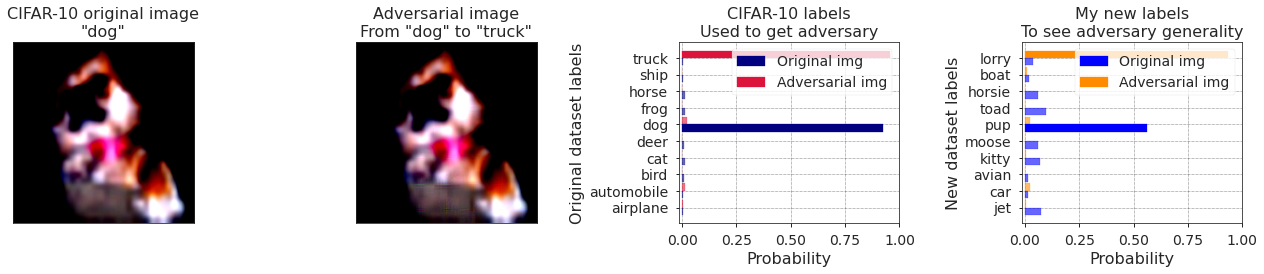

In [ ]:
N_images_to_show = 10

for id_to_show in range(min([orignames_original_preds_now.shape[0],N_images_to_show])):

  plt.figure(figsize = (4*4.5,4))

  plt.subplot(1,4,3)
  plt.title("CIFAR-10 labels\nUsed to get adversary",fontsize = 16)
  make_plot_from_preds(orignames_original_preds_now[id_to_show],orignames_modified_preds_now[id_to_show],class_names)
  plt.ylabel("Original dataset labels")

  plt.subplot(1,4,4)
  plt.title("My new labels\nTo see adversary generality",fontsize = 16)
  make_plot_from_preds(original_preds_now[id_to_show],modified_preds_now[id_to_show],alternative_class_names,["blue","darkorange"])
  plt.ylabel("New dataset labels")

  plt.subplot(1,4,1)
  plt.title("CIFAR-10 original image\n\""+class_names[collected_original_labels[id_to_show]]+"\"",fontsize = 16)
  plt.imshow(collected_original_images[id_to_show][0].transpose([1,2,0]))
  plt.grid(False)
  plt.xticks([],[])
  plt.yticks([],[])

  plt.subplot(1,4,2)
  plt.title("Adversarial image\nFrom \""+class_names[collected_original_labels[id_to_show]]+"\" to \""+class_names[collected_modified_labels[id_to_show]]+"\"",fontsize = 16)
  plt.imshow(collected_modified_images[id_to_show][0].transpose([1,2,0]))
  plt.grid(False)
  plt.xticks([],[])
  plt.yticks([],[])

  plt.tight_layout()

  plt.show()

## Super broad class names

In [ ]:
#using very long winded descriptive class names
cifar10_class_names_verybroad = [
  ["vehicle that flies in the air"],
  ["personal vehicle that drives on land"],
  ["winged animal that flies in the sky"],
  ["domesticated animal which eats mice and meows"],
  ["animal that lives in the forest and has antlers"],
  ["domesticated animal which barks and is best friend"],
  ["small animal in swamps which eats flies, croaks"],
  ["large animal with four legs, eats hay, people ride on it"],
  ["vehicle that travels on water, ocean and sea"],
  ["big road vehicle that transports cargo"],
]

In [ ]:
alternative_class_names = [q[0] for q in cifar10_class_names_verybroad]

print(alternative_class_names)

modified_preds_now = classify_images(np.concatenate(collected_modified_images,axis=0), alternative_class_names, skip_transform=True, verbose=False)
original_preds_now = classify_images(np.concatenate(collected_original_images,axis=0), alternative_class_names, skip_transform=True, verbose=False)

original_acc_now = np.mean(np.argmax(original_preds_now,axis=-1) == np.array(collected_original_labels))
modified_acc_now = np.mean(np.argmax(modified_preds_now,axis=-1) == np.array(collected_modified_labels))

print("Original images and original labels accuracy = "+str(original_acc_now))
print("Adversarial images and adversarial labels accuracy = "+str(modified_acc_now))

#original class names for comparison
orignames_modified_preds_now = classify_images(np.concatenate(collected_modified_images,axis=0), class_names, skip_transform=True, verbose=False)
orignames_original_preds_now = classify_images(np.concatenate(collected_original_images,axis=0), class_names, skip_transform=True, verbose=False)

['vehicle that flies in the air', 'personal vehicle that drives on land', 'winged animal that flies in the sky', 'domesticated animal which eats mice and meows', 'animal that lives in the forest and has antlers', 'domesticated animal which barks and is best friend', 'small animal in swamps which eats flies, croaks', 'large animal with four legs, eats hay, people ride on it', 'vehicle that travels on water, ocean and sea', 'big road vehicle that transports cargo']
Original images and original labels accuracy = 1.0
Adversarial images and adversarial labels accuracy = 0.3


### Plotting the generalization of adversaries to the very broad names

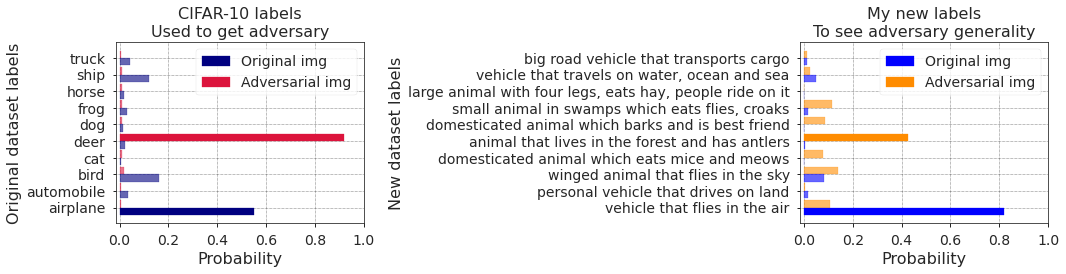

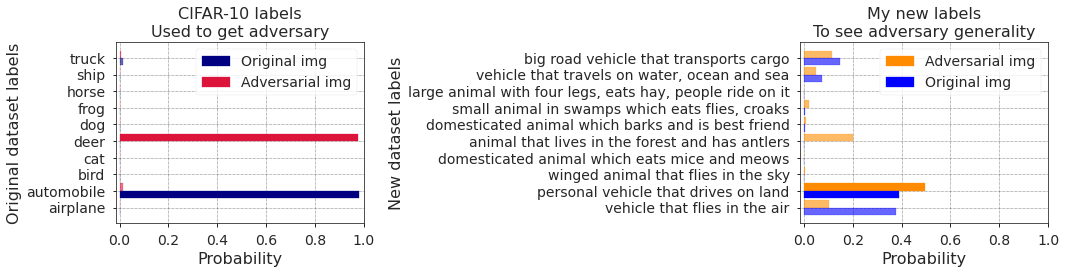

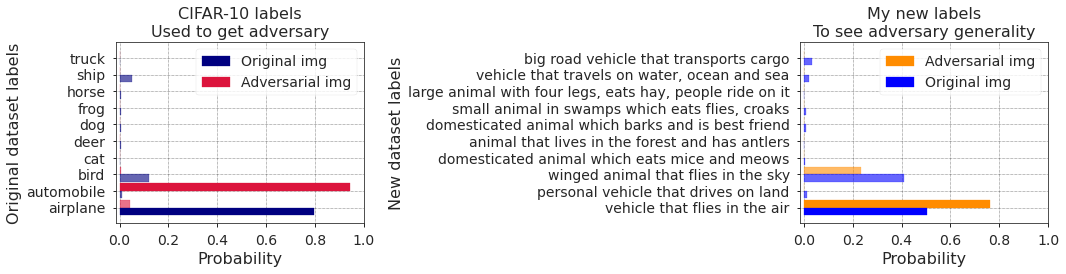

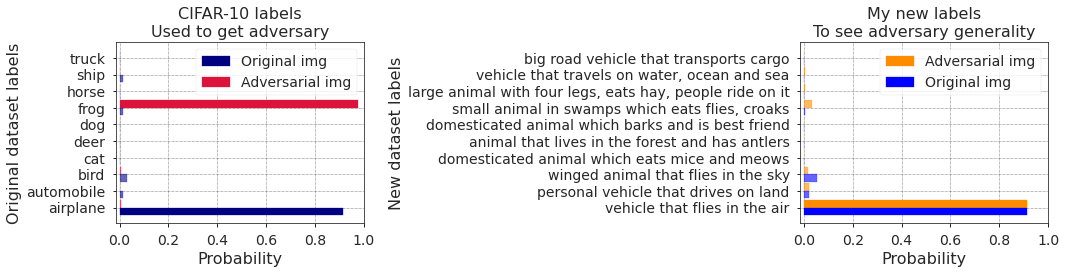

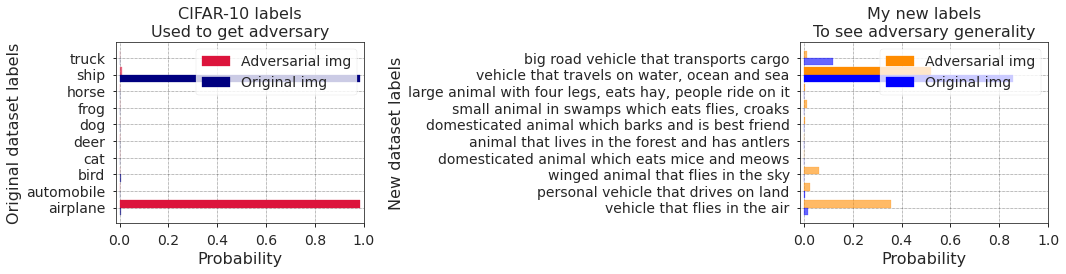

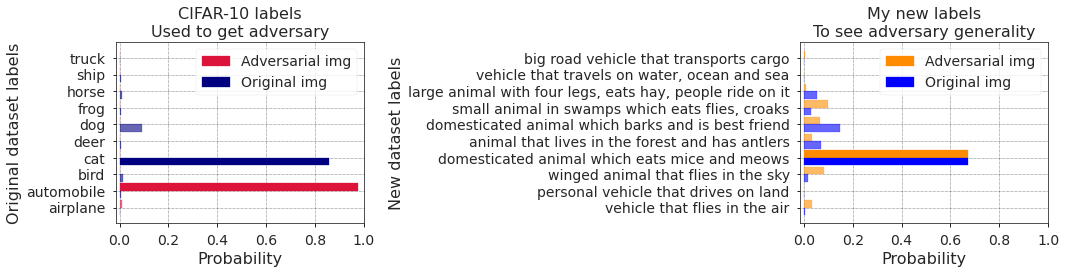

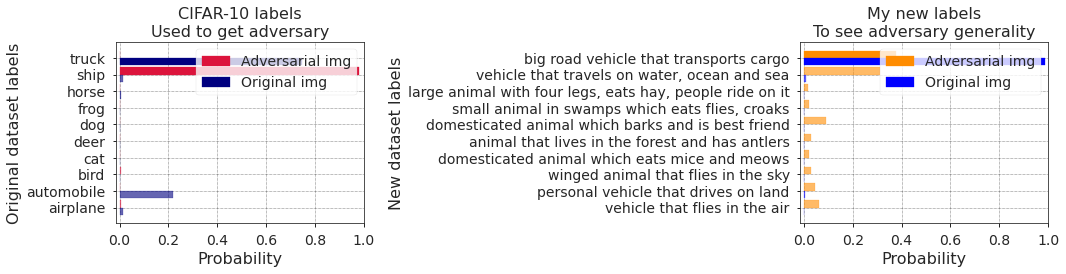

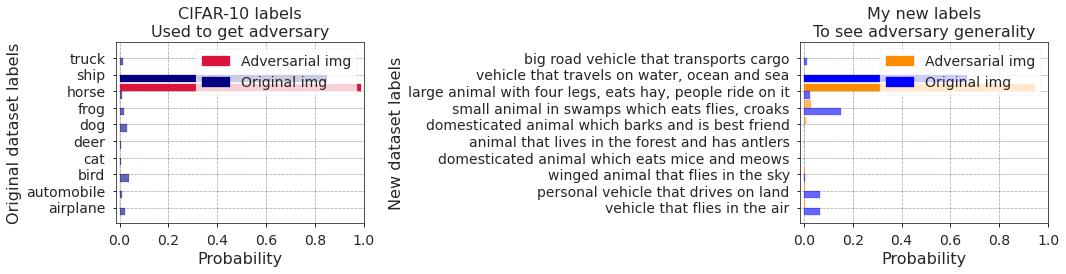

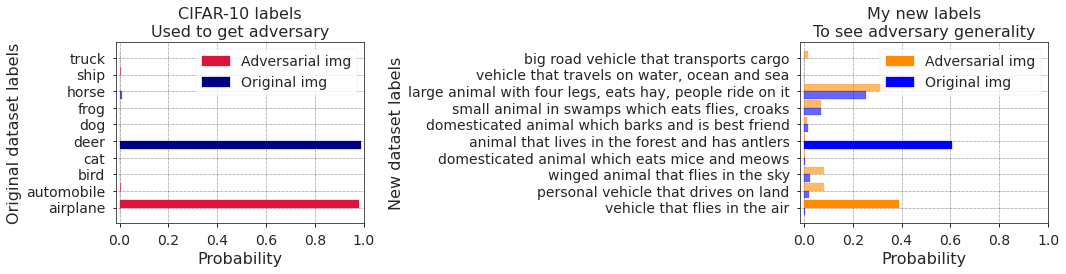

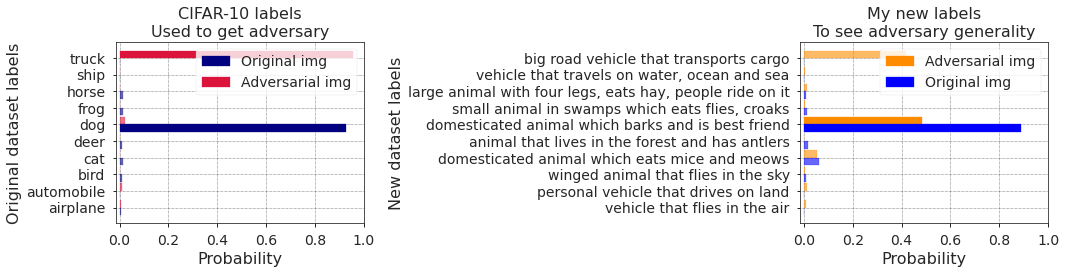

In [ ]:
N_images_to_show = 10

for id_to_show in range(min([orignames_original_preds_now.shape[0],N_images_to_show])):

  plt.figure(figsize = (15,4))

  plt.subplot(1,2,1)
  plt.title("CIFAR-10 labels\nUsed to get adversary",fontsize = 16)
  make_plot_from_preds(orignames_original_preds_now[id_to_show],orignames_modified_preds_now[id_to_show],class_names)
  plt.ylabel("Original dataset labels")

  plt.subplot(1,2,2)
  plt.title("My new labels\nTo see adversary generality",fontsize = 16)
  make_plot_from_preds(original_preds_now[id_to_show],modified_preds_now[id_to_show],alternative_class_names,["blue","darkorange"])
  plt.ylabel("New dataset labels")

  plt.tight_layout()

  plt.show()